In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import pyarrow.parquet as pq
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose


In [48]:
train_df = pd.read_parquet('../Data/Data files/train_data.parquet')


train_df.shape

#df = pd.concat([train_df, test_df], sort=False)

(2812490, 20)

In [ ]:
df.tail()

,brand,phase,country,dayweek,month,wd_perc,ther_area,hospital_rate,n_nwd_bef,n_nwd_aft,n_weekday_0,n_weekday_1,n_weekday_2,n_weekday_3,n_weekday_4,date,wd,wd_left,monthly,main_channel
11918,ZKKLD,NaN,Zamunda,0.0,12.0,0.733333,R,0.00088,2.0,0.0,3,3,3,2,4,2022-12-19,11,4,NaN,RETAIL
11919,ZKKLD,NaN,Zamunda,1.0,12.0,0.800000,R,0.00088,0.0,0.0,3,3,3,2,4,2022-12-20,12,3,NaN,RETAIL
11920,ZKKLD,NaN,Zamunda,2.0,12.0,0.866667,R,0.00088,0.0,0.0,3,3,3,2,4,2022-12-21,13,2,NaN,RETAIL
11921,ZKKLD,NaN,Zamunda,3.0,12.0,0.933333,R,0.00088,0.0,0.0,3,3,3,2,4,2022-12-22,14,1,NaN,RETAIL
11922,ZKKLD,NaN,Zamunda,4.0,12.0,1.000000,R,0.00088,0.0,9.0,3,3,3,2,4,2022-12-23,15,0,NaN,RETAIL


### Data exploration

In [3]:
#Check for general data description
df.describe().T

NameError: name 'df' is not defined

In [ ]:
# Seek for missing values
train_df.isnull().sum()

In [ ]:
train_df.groupby(["country", "brand"]).agg({"phase" : ["sum", "mean", "median", "std"]})

<Figure size 640x480 with 0 Axes>

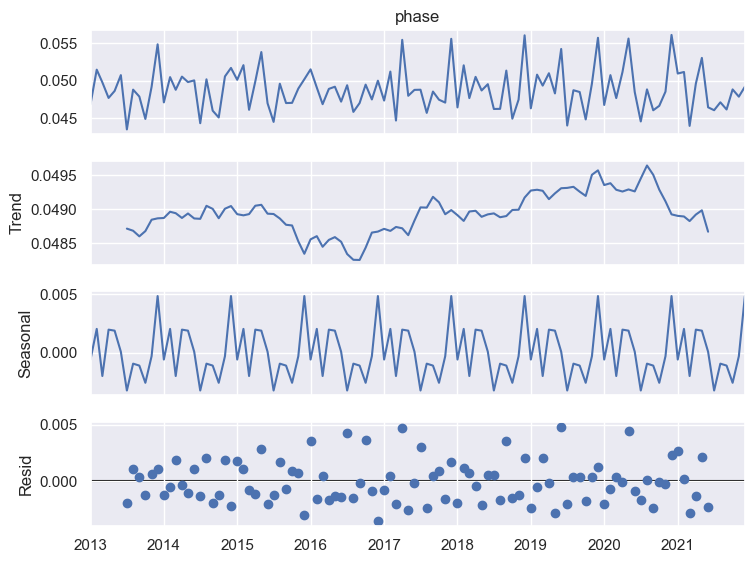

In [150]:
train_plot = train_df.set_index('date')
y = train_plot['phase'].resample('MS').mean() 

result = seasonal_decompose(y, model='additive')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(8, 6)

### Feature engineering

In [49]:
# Extracting the date from the datetime column
train_df['day'] = train_df['date'].dt.day
train_df['month'] = train_df['date'].dt.month
train_df['year'] = train_df['date'].dt.year
train_df['quarter_of_year'] = train_df['date'].dt.quarter
train_df['is_month_start'] = train_df.date.dt.is_month_start.astype(int)
train_df['is_month_end'] = train_df.date.dt.is_month_end.astype(int)
train_df['week_of_year'] = train_df.date.dt.weekofyear
train_df['is_month_start'] = train_df.date.dt.is_month_start.astype(int)
train_df['is_month_end'] = train_df.date.dt.is_month_end.astype(int)

C:\Users\Guim\AppData\Local\Temp\ipykernel_12124\12388227.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train_df['week_of_year'] = train_df.date.dt.weekofyear


##### Lag features

In [50]:
def random_noise(dataframe):
    return np.random.normal(scale=1.5, size=(len(dataframe),))

In [51]:
def lag_features(dataframe, lag_list):
    for lag in lag_list:
        s = str(lag[0]) + "_" + lag[1]
        if lag[1] == 'day':
            dataframe['date_' + s] = dataframe['date'] - pd.Timedelta(days=lag[0])
        elif lag[1] == 'month':
            dataframe['date_' + s] = dataframe['date'] - pd.offsets.MonthBegin(n=lag[0])
        
        if 'phase_lag_' + s in dataframe.columns:
            dataframe.drop(['phase_lag_' + s], axis=1, inplace=True)

        dataframe = dataframe.merge(dataframe[['brand', 'country', 'date', 'phase']], 
                     left_on=['brand', 'country', 'date_' + s], 
                     right_on=['brand', 'country', 'date'], 
                     suffixes=('', '_lag_' + s), 
                     how='left')
        
        
        
        dataframe.drop(['date_' + s, 'date_lag_' + s], axis=1, inplace=True)
        dataframe['phase_lag_' + s].fillna(0, inplace=True)
        
        # Add random noise to the lagged feature
        dataframe['phase_lag_' + s] = dataframe['phase_lag_' + s].fillna(0) + random_noise(dataframe)
        
        
    return dataframe

In [52]:
lag_days = [1, 2, 3, 7, 14, 182, 365]

In [53]:
train_df.sort_values(by=['country', 'brand', 'date'], inplace=True)

train_df = lag_features(train_df, [[1, 'day'], [2, 'day'], [3, 'day'], [7, 'day'], [14, 'day'], [182, 'day'], [365, 'day']])

##### Roll features

In [55]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        roll_mean_col = f'phase_roll_mean_{window}'

        if roll_mean_col in dataframe.columns:
           dataframe.drop(roll_mean_col, axis=1, inplace=True)
        
        
        # Create a column for the date at the start of the window period
        window_start_date_col = 'window_start_date_' + str(window)
        dataframe[window_start_date_col] = dataframe['date'] - pd.Timedelta(days=window)


        merged_df = dataframe.merge(
            dataframe[['brand', 'country', 'date', 'phase']],
            left_on=['brand', 'country', window_start_date_col],
            right_on=['brand', 'country', 'date'],
            how='left',
            suffixes=('', '_right')
        )

        rolled_means = merged_df.groupby(['brand', 'country', 'date_right'])[f'phase'].mean()


        # Create a temporary DataFrame to facilitate correct index alignment
        temp_df = pd.DataFrame(dataframe[['brand', 'country', 'date']].drop_duplicates())
        temp_df.set_index(['brand', 'country', 'date'], inplace=True)
        temp_df[roll_mean_col] = rolled_means

        # Map the rolled means back to the original dataframe
        dataframe[roll_mean_col] = dataframe.set_index(['brand', 'country', 'date']).index.map(temp_df[roll_mean_col])
        # Map the rolled means back to the original dataframe        
        # Add random noise
        #dataframe[f'phase_roll_mean_{window}'] += random_noise(dataframe)
        dataframe[roll_mean_col].fillna(0, inplace=True)
        
        # Clean up temporary columns
        dataframe.drop(window_start_date_col, axis=1, inplace=True)
        
        print("Finised rolling mean for window: ", window)

    return dataframe

In [56]:
roll_days = [7, 14, 30, 60, 90, 180, 365]

In [57]:

train_df = roll_mean_features(train_df, roll_days)

Finised rolling mean for window:  7
Finised rolling mean for window:  14
Finised rolling mean for window:  30
Finised rolling mean for window:  60
Finised rolling mean for window:  90
Finised rolling mean for window:  180
Finised rolling mean for window:  365


In [ ]:
train_df[train_df['country'] == 'Aldovia'][train_df['brand'] == 'AIMST'][0:50][['date', 'phase', 'phase_lag_1_day', 'phase_lag_2_day', 'phase_lag_3_day', 'phase_lag_7_day', 'phase_lag_14_day', 'phase_roll_mean_7', 'phase_roll_mean_14', 'phase_roll_mean_30']]#, 'phase_roll_mean_60', 'phase_roll_mean_90', 'phase_roll_mean_180', 'phase_roll_mean_365']]


In [ ]:

# Splitting the data into X and y
X_df = train_df[num_used_features + cat_used_features]
y_df = train_df['phase']


In [ ]:


# Split the data into training and testing sets based on the year
X_train_df = X_df[X_df['year'] == 2020]
y_train = y_df[X_df['year'] == 2020]
X_test_df = X_df[X_df['year'] >= 2021]
y_test = y_df[X_df['year'] >= 2021]

In [ ]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform on training data
X_train_encoded = encoder.fit_transform(X_train_df[['country', 'brand']])
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(['country', 'brand']))
X_train_combined = pd.concat([X_train_encoded_df, X_train_df[['day', 'month', 'year']].reset_index(drop=True)], axis=1)

# Transform the test data
X_test_encoded = encoder.transform(X_test_df[['country', 'brand']])
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(['country', 'brand']))
X_test_combined = pd.concat([X_test_encoded_df, X_test_df[['day', 'month', 'year']].reset_index(drop=True)], axis=1)


##### Encodings

##### Old encodings and split

In [58]:

# Store categorical features for different treatment
cat_features = ['brand', 'country', 'ther_area', 'main_channel']
cat_used_features = ['brand', 'country']
num_used_features = ['day', 'month', 'year', 'phase_lag_7']


In [187]:
train_df.columns

Index(['brand', 'phase', 'country', 'dayweek', 'month', 'wd_perc', 'ther_area',
       'hospital_rate', 'n_nwd_bef', 'n_nwd_aft', 'n_weekday_0', 'n_weekday_1',
       'n_weekday_2', 'n_weekday_3', 'n_weekday_4', 'date', 'wd', 'wd_left',
       'monthly', 'main_channel', 'day', 'year', 'quarter_of_year',
       'phase_lag_1_day', 'phase_lag_2_day', 'phase_lag_3_day',
       'phase_lag_7_day', 'phase_lag_14_day', 'phase_roll_mean_7',
       'phase_roll_mean_14', 'phase_roll_mean_30'],
      dtype='object')

In [59]:
train_df_encoded = pd.get_dummies(train_df, columns=cat_used_features, drop_first=False)
train_df_encoded['country'] = train_df['country']
train_df_encoded['brand'] = train_df['brand']

In [233]:
train_df_encoded.country

0          Aldovia
1          Aldovia
2          Aldovia
3          Aldovia
4          Aldovia
            ...   
3525877    Zamunda
3525878    Zamunda
3525879    Zamunda
3525880    Zamunda
3525881    Zamunda
Name: country, Length: 2812490, dtype: object

In [60]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(preds, labels)
    return 'SMAPE', smape_val, False

In [17]:
initial_columns = ['brand', 'phase', 'country', 'dayweek', 'month', 'wd_perc', 'ther_area',
       'hospital_rate', 'n_nwd_bef', 'n_nwd_aft', 'n_weekday_0', 'n_weekday_1',
       'n_weekday_2', 'n_weekday_3', 'n_weekday_4', 'date', 'wd', 'wd_left',
       'monthly', 'main_channel']

d = ['brand', 'phase', 'country', 'wd_perc', 'ther_area',
       'hospital_rate', 'n_nwd_bef', 'n_nwd_aft', 'n_weekday_0', 'n_weekday_1',
       'n_weekday_2', 'n_weekday_3', 'n_weekday_4', 'date', 'wd', 'wd_left',
       'monthly', 'main_channel']

initial_columns_to_drop = ['brand', 'phase', 'country', 'wd_perc', 'ther_area',
       'hospital_rate', 'date',,
       'monthly', 'main_channel']

In [18]:
train = train_df_encoded.loc[(train_df_encoded['year'] == 2020), :]

test = train_df_encoded.loc[(train_df_encoded['year'] >= 2021), :]

cols = [col for col in train.columns if col not in initial_columns_to_drop]

y_train = train['phase']
X_train = train[cols]

y_test = test['phase']
X_test = test[cols]

In [19]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [20]:
lgbtrain = lgb.Dataset(data=X_train, label=y_train, feature_name=cols)

lgbval = lgb.Dataset(data=X_test, label=y_test, reference=lgbtrain, feature_name=cols)

In [21]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  callbacks=[
                   lgb.early_stopping(stopping_rounds=lgb_params['early_stopping_rounds'])    
                  ],
                  feval=lgbm_smape,
                  )

C:\Users\Guim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds


In [214]:
y_pred_val = model.predict(X_test, num_iteration=model.best_iteration)

In [153]:
predictions = X_test
        

In [215]:
smape(y_pred_val, y_test)

90.35005888897507

In [197]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show(block=True)
    else:
        print(feat_imp.head(num))
    return feat_imp

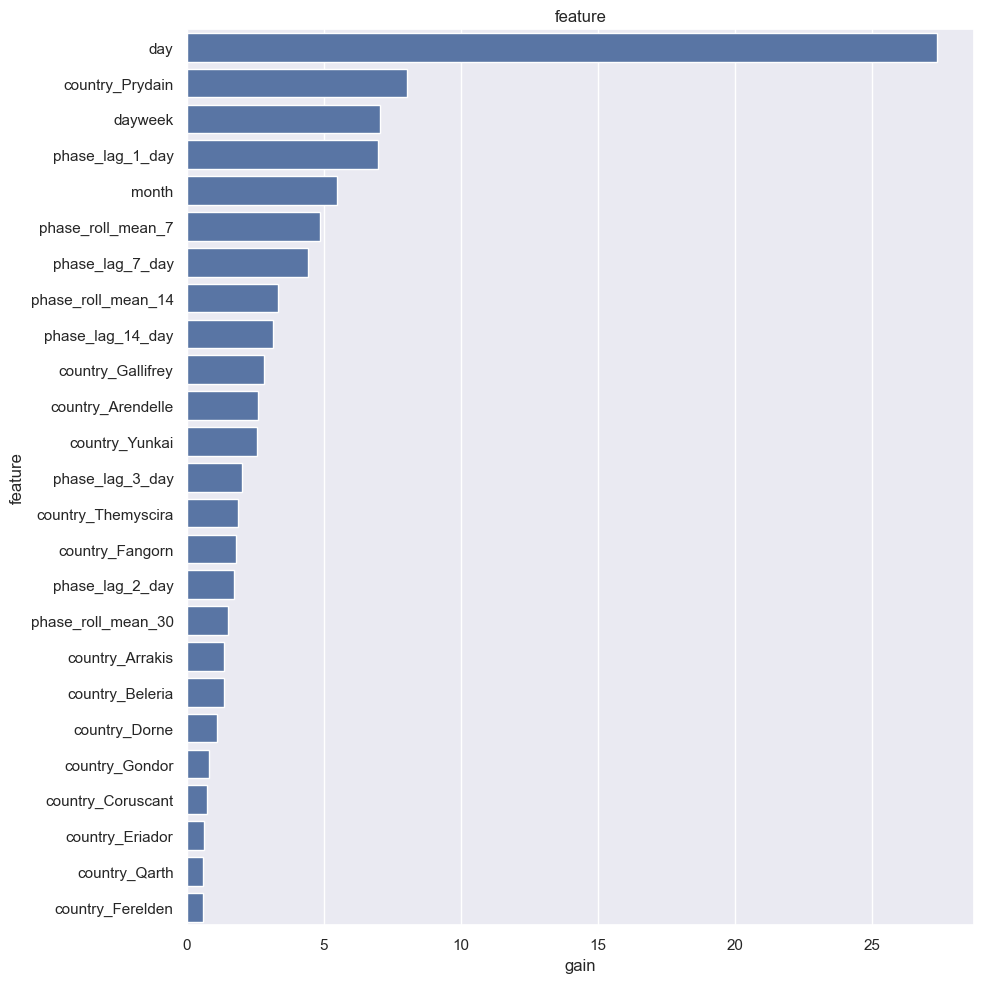

,feature,split,gain
2,day,6845,27.353412
292,country_Prydain,772,8.048241
0,dayweek,2991,7.041888
5,phase_lag_1_day,2491,6.992075
1,month,2885,5.499495
...,...,...,...
139,brand_LSKEI,0,0.000000
140,brand_LTOHO,0,0.000000
141,brand_LYWEQ,0,0.000000
142,brand_MFPBG,0,0.000000


In [216]:
plot_lgb_importances(model, num=30, plot=True)

In [151]:
def metric(df: pd.DataFrame) -> float:
    """Compute performance metric.

    :param df: Dataframe with target ('phase') and 'prediction', and identifiers.
    :return: Performance metric
    """
    df = df.copy()
    #assert 'monthly' in df.columns, "Missing 'monthly' column, only available in the train set"
    #assert 'phase' in df.columns, "Missing 'phase' column, only available in the train set"
    #assert 'prediction' in df.columns, "Missing 'prediction' column with predictions"

    df["date"] = pd.to_datetime(df["date"])
    
    # create datetime columns
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter

    # Sum of phasing country-brand-month = 1
    df['sum_pred'] = df.groupby(['year', 'month', 'brand', 'country'])['prediction'].transform(sum)
    assert np.isclose(df['sum_pred'], 1.0, rtol=1e-04).all(), "Condition phasing year-month-brand-country must sum 1 is not fulfilled"
    
    # define quarter weights 
    df['quarter_w'] = np.where(df['quarter'] == 1, 1, 
                    np.where(df['quarter'] == 2, 0.75,
                    np.where(df['quarter'] == 3, 0.66, 0.5)))
                    
    # compute and return metric
    return round(np.sqrt((1 / len(df)) * sum(((df['phase'] - df['prediction'])**2) * df['quarter_w'] * df['monthly'])), 8)

In [154]:
new_train_df = pd.read_parquet('../Data/Data files/train_data.parquet')
new_train_df.sort_values(by=['country', 'brand', 'date'], inplace=True)
df_train = new_train_df[new_train_df['date'].dt.year.isin([2021])]

y_test = y_test.reset_index(drop=True)
y_pred_val = pd.Series(y_pred_val).reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

print(y_test.shape, y_pred_val.shape, df_train.country.shape,)

(306913,) (306913,) (306913,)


In [199]:
train.head()

,brand,phase,country,dayweek,month,wd_perc,ther_area,hospital_rate,n_nwd_bef,n_nwd_aft,...,year,quarter_of_year,phase_lag_1_day,phase_lag_2_day,phase_lag_3_day,phase_lag_7_day,phase_lag_14_day,phase_roll_mean_7,phase_roll_mean_14,phase_roll_mean_30
1601,AIMST,0.214893,Aldovia,1.0,3,0.047619,NaN,NaN,3.0,0.0,...,2020,1,0.000000,0.000000,0.000000,0.0,0.0,0.070299,0.078570,0.015514
1602,AIMST,0.030511,Aldovia,2.0,3,0.095238,NaN,NaN,0.0,0.0,...,2020,1,0.214893,0.000000,0.000000,0.0,0.0,0.053761,0.002891,0.110253
1603,AIMST,0.082794,Aldovia,3.0,3,0.142857,NaN,NaN,0.0,0.0,...,2020,1,0.030511,0.214893,0.000000,0.0,0.0,0.047188,0.036339,0.000000
1604,AIMST,0.032576,Aldovia,4.0,3,0.190476,NaN,NaN,0.0,2.0,...,2020,1,0.082794,0.030511,0.214893,0.0,0.0,0.019589,0.011570,0.000000
1605,AIMST,0.031081,Aldovia,0.0,3,0.238095,NaN,NaN,2.0,0.0,...,2020,1,0.000000,0.000000,0.032576,0.0,0.0,0.027025,0.073366,0.044068


In [236]:
test['brand']

1789       AIMST
1790       AIMST
1791       AIMST
1792       AIMST
1793       AIMST
           ...  
3523148    ZKMVW
3523149    ZKMVW
3523150    ZKMVW
3523151    ZKMVW
3523152    ZKMVW
Name: brand, Length: 306913, dtype: object

In [237]:

df_val_predictions = pd.DataFrame({
    'phase': test['phase'], 
    'prediction': y_pred_val, 
    'monthly': test['monthly'], 
    'date': test['date'], 
    'brand': test['brand'], 
    'country': test['country']
})

In [238]:
performance_metric = metric(df_val_predictions)

print(f'Performance Metric: {performance_metric}')

Performance Metric: 0.00900054


In [239]:
test.columns

Index(['phase', 'dayweek', 'month', 'wd_perc', 'ther_area', 'hospital_rate',
       'n_nwd_bef', 'n_nwd_aft', 'n_weekday_0', 'n_weekday_1',
       ...
       'country_Qarth', 'country_Sokovia', 'country_Themyscira',
       'country_Vulcan', 'country_Wakanda', 'country_Westeros',
       'country_Yunkai', 'country_Zamunda', 'country', 'brand'],
      dtype='object', length=311)

In [207]:
print(test.shape, test.shape)

(306913, 32) (306913, 32)


In [241]:
#Normalise predictions

test['prediction'] = y_pred_val

test['sum_pred'] = test.groupby(['year', 'month', 'brand', 'country'])['prediction'].transform('sum')

test['normalized_prediction'] = test['prediction'] / test['sum_pred']

C:\Users\Guim\AppData\Local\Temp\ipykernel_2180\110733548.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = y_pred_val
C:\Users\Guim\AppData\Local\Temp\ipykernel_2180\110733548.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['sum_pred'] = test.groupby(['year', 'month', 'brand', 'country'])['prediction'].transform('sum')
C:\Users\Guim\AppData\Local\Temp\ipykernel_2180\110733548.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [61]:
test_df = pd.read_parquet('../Data/Data files/submission_data.parquet')

In [62]:
# Extracting the date from the datetime column
test_df['day'] = test_df['date'].dt.day
test_df['month'] = test_df['date'].dt.month
test_df['year'] = test_df['date'].dt.year
test_df['quarter_of_year'] = test_df['date'].dt.quarter

In [63]:
test_df.sort_values(by=['country', 'brand', 'date'], inplace=True)

In [64]:
test_df_encoded = pd.get_dummies(test_df, columns=cat_used_features, drop_first=False)
test_df_encoded['country'] = test_df['country']
test_df_encoded['brand'] = test_df['brand']

In [65]:
train = train_df_encoded

cols_T = [col for col in train.columns if col not in initial_columns_to_drop]

Y_train = train['phase']
X_train = train[cols_T]



test = test_df_encoded

cols_V = [col for col in test.columns if col not in initial_columns_to_drop]

X_test = test[cols_V]

missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0

C:\Users\Guim\AppData\Local\Temp\ipykernel_12124\3569796065.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = 0
C:\Users\Guim\AppData\Local\Temp\ipykernel_12124\3569796065.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = 0
C:\Users\Guim\AppData\Local\Temp\ipykernel_12124\3569796065.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [66]:
print(test.shape, X_test.shape)

(180845, 140) (180845, 310)


In [76]:
X_train.shape

(2812490, 310)

In [68]:
X_test.shape

(180845, 310)

In [53]:
set(X_test.columns) - set(X_train.columns)

set()

In [69]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 40,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

In [79]:
X_train.shape

(2812490, 310)

In [70]:
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols_T)
final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)

C:\Users\Guim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [90]:
X_train.shape

(2812490, 301)

In [71]:
date_to_index = {row['date']: idx for idx, row in test.iterrows()}

for roll_day in roll_days:
    # Calculate rolling mean from the training data
    end_date = train['date'].max()  # Last date in the training data
    start_date = end_date - pd.Timedelta(days=roll_day)
    mask = (train['date'] > start_date) & (train['date'] <= end_date)
    rolling_mean_value = train.loc[mask, 'phase'].mean()
    X_test[f'phase_roll_mean_{roll_day}'] = rolling_mean_value

In [96]:
current_features = X_test.iloc[0].values.reshape(1, -1)
current_features.shape

(1, 301)

In [72]:
from tqdm import tqdm

In [80]:
print(test.shape, X_test.shape)


(180845, 140) (180845, 310)


In [81]:
print(X_train.shape, X_test.shape)

(2812490, 310) (180845, 310)


In [114]:
test.reset_index(drop=True, inplace=True)

test['date'][108640]

Timestamp('2022-05-23 00:00:00')

In [74]:

test.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

X_test_np = X_test.to_numpy()
y_pred_val = []

lookback_dates = {roll_days: [test['date'][i] - pd.Timedelta(days=roll_days) for i in range(len(X_test_np))] for roll_days in [7, 14, 30]}

In [82]:

for i in tqdm(range(len(X_test)), desc="Predicting"):
    # Predict phase for the current row
    current_features = X_test.iloc[i].values.reshape(1, -1).copy()
    current_pred = final_model.predict(current_features, num_iteration=model.best_iteration)
    y_pred_val.append(current_pred[0])

    # Update lag features and calculate rolling means based on dates for the next row
    if i + 1 < len(X_test_np):
        for roll_day in [7, 14, 30]:
            lookback_date = lookback_dates[roll_day][i + 1]
            relevant_indices = [date_to_index[d] for d in date_to_index if lookback_date <= d < test['date'][i + 1]]
            relevant_phases = [y_pred_val[idx] for idx in relevant_indices if idx <= i]
            rolling_mean = np.mean(relevant_phases) if relevant_phases else rolling_mean_value
            X_test_np[i + 1, X_test.columns.get_loc(f'phase_roll_mean_{roll_day}')] = rolling_mean

Predicting: 100%|██████████| 180845/180845 [19:16<00:00, 156.35it/s]


In [87]:
y_pred_val[:10]

array([0.037412  , 0.0464336 , 0.04474788, 0.04925389, 0.04733571,
       0.04266818, 0.04340014, 0.0421607 , 0.04573588, 0.04396471])

In [88]:
submission = pd.read_csv('../Data/Data files/submission_template.csv')

In [89]:
#Turn negatives to 0
y_pred_val = np.array(y_pred_val)  # Ensure y_pred_val is a numpy array

y_pred_val[y_pred_val < 0] = 0

In [90]:
#Normalise predictions

test['prediction'] = y_pred_val
test['sum_pred'] = test.groupby(['year', 'month', 'brand', 'country'])['prediction'].transform('sum')

test['normalized_prediction'] = test['prediction'] / test['sum_pred']

test.reset_index(drop=True, inplace=True)


In [91]:
submission['prediction'] = test['normalized_prediction']

In [92]:
submission.head()

,country,brand,date,prediction
0,Aldovia,AIMST,2022-01-03,0.044609
1,Aldovia,AIMST,2022-01-04,0.055366
2,Aldovia,AIMST,2022-01-05,0.053356
3,Aldovia,AIMST,2022-01-06,0.058729
4,Aldovia,AIMST,2022-01-07,0.056442


In [93]:
submission.to_csv('../Submissions/submission2.csv', index=False)

In [94]:
submission[submission['prediction'] < 0]

,country,brand,date,prediction


In [97]:
import xgboost as xgb

In [99]:
xgb_params = {
    'objective': 'reg:squarederror',  # for regression tasks; use 'binary:logistic' for classification
    'max_depth': 5,  # similar to LightGBM
    'learning_rate': 0.02,  # similar to LightGBM
    'subsample': 0.8,  # similar to 'feature_fraction' in LightGBM
    'colsample_bytree': 0.8,  # similar to feature_fraction, but for tree level
    'n_estimators': model.best_iteration,  # similar to num_boost_round in LightGBM
    'n_jobs': -1,  # similar to 'nthread' in LightGBM
    'eval_metric': 'mae',  # similar to 'metric' in LightGBM
    'verbosity': 0  # similar to 'verbose' in LightGBM
}
dtrain = xgb.DMatrix(X_train, label=Y_train)


In [108]:
X_train.shape

(2812490, 310)

In [101]:
xgb_model = xgb.train(xgb_params, dtrain, 2000, evals=[(dtrain, 'train')], maximize=False, verbose_eval=100)

[0]	train-mae:0.03989
[100]	train-mae:0.03821
[200]	train-mae:0.03770
[300]	train-mae:0.03738
[400]	train-mae:0.03714
[500]	train-mae:0.03693
[600]	train-mae:0.03674
[700]	train-mae:0.03656
[800]	train-mae:0.03638
[900]	train-mae:0.03622
[1000]	train-mae:0.03607
[1100]	train-mae:0.03596
[1200]	train-mae:0.03586
[1300]	train-mae:0.03578
[1400]	train-mae:0.03570
[1500]	train-mae:0.03563
[1600]	train-mae:0.03557
[1700]	train-mae:0.03552
[1800]	train-mae:0.03546
[1900]	train-mae:0.03541
[1999]	train-mae:0.03537


In [109]:
X_test.shape

(180845, 310)

In [107]:
y_pred_val_xgb = []
for i in tqdm(range(len(X_test)), desc="Predicting"):
    # Convert current features to DMatrix format
    current_features = X_test.iloc[i].values.reshape(1, -1)
    dcurrent = xgb.DMatrix(current_features)
    
    # Predict phase for the current row
    current_pred = xgb_model.predict(dcurrent)
    y_pred_val_xgb.append(current_pred[0])

    # Update lag features and calculate rolling means based on dates for the next row
    if i + 1 < len(X_test):
        for roll_day in [7, 14, 30]:
            lookback_date = lookback_dates[roll_day][i + 1]
            relevant_indices = [date_to_index[d] for d in date_to_index if lookback_date <= d < X_test['date'].iloc[i + 1]]
            relevant_phases = [y_pred_val_xgb[idx] for idx in relevant_indices if idx <= i]
            rolling_mean = np.mean(relevant_phases) if relevant_phases else rolling_mean_value
            X_test.at[i + 1, f'phase_roll_mean_{roll_day}'] = rolling_mean

Predicting:   0%|          | 0/180845 [00:00<?, ?it/s]


ValueError: training data did not have the following fields: dayweek, month, day, year, quarter_of_year, is_month_start, is_month_end, week_of_year, phase_lag_1_day, phase_lag_2_day, phase_lag_3_day, phase_lag_7_day, phase_lag_14_day, phase_lag_182_day, phase_lag_365_day, phase_roll_mean_7, phase_roll_mean_14, phase_roll_mean_30, phase_roll_mean_60, phase_roll_mean_90, phase_roll_mean_180, phase_roll_mean_365, brand_ABRRE, brand_AIMST, brand_AITPJ, brand_AIZTT, brand_AMOKR, brand_AMQQS, brand_ARBSZ, brand_BBIDC, brand_BELQI, brand_BFFIN, brand_BJZQP, brand_BNCPE, brand_BQSIJ, brand_BRBUX, brand_BRQJC, brand_BSZFS, brand_BUMTY, brand_BZJGB, brand_CCXTL, brand_CDFFX, brand_CFCMT, brand_CPHZR, brand_CQSEZ, brand_CQXPP, brand_CUEHC, brand_CXGRE, brand_CYUJX, brand_DAPTX, brand_DBEYQ, brand_DDRNC, brand_DKCQN, brand_DKGUK, brand_DKNSS, brand_DLOBM, brand_DRGNL, brand_DWBKI, brand_DXGSD, brand_DXHFH, brand_EAHGQ, brand_EDPMR, brand_EGDMS, brand_EINXZ, brand_EJXYC, brand_ELXGP, brand_EMZJL, brand_EPFRE, brand_EQZWB, brand_ERYNY, brand_ESVUF, brand_EUESX, brand_EUJWP, brand_EWENN, brand_FIPNP, brand_FJVNL, brand_FLGPE, brand_FNHPF, brand_FQGFS, brand_FQQZN, brand_FTFTW, brand_FULHM, brand_FUYDW, brand_GBWHQ, brand_GCGOD, brand_GFTPG, brand_GIKKL, brand_GLYEH, brand_GUCEF, brand_GXCBP, brand_GYMRM, brand_HAGBD, brand_HFUTE, brand_HGSMA, brand_HGXNC, brand_HHBXR, brand_HIBSM, brand_HJDCK, brand_HOIWJ, brand_HPCEJ, brand_HPTIP, brand_HRQUR, brand_HTRHP, brand_HZCGL, brand_IBFOZ, brand_ICEII, brand_ICPTW, brand_IDMBR, brand_IERNH, brand_IHGCP, brand_IHUXD, brand_IHYWC, brand_IKGEA, brand_ILMXM, brand_IMUFR, brand_IMVCZ, brand_INOMT, brand_IYDRY, brand_IYPIH, brand_JAZVP, brand_JJVUD, brand_JMSOC, brand_JQKXY, brand_JTOEV, brand_JVKMG, brand_JZIWZ, brand_KCCMS, brand_KCSWZ, brand_KCYIY, brand_KDECS, brand_KGUIR, brand_KJXID, brand_KKZMZ, brand_KLYXW, brand_KMXBC, brand_KQEDP, brand_KVWWC, brand_KXHAE, brand_KXUSS, brand_LCSIH, brand_LCXHV, brand_LESHW, brand_LFJNN, brand_LGFTN, brand_LIIDH, brand_LJKGD, brand_LOYFW, brand_LRHOW, brand_LSKEI, brand_LTOHO, brand_LYWEQ, brand_MFPBG, brand_MILBQ, brand_MLKJM, brand_MNZCG, brand_MOAJK, brand_MRHKP, brand_MYJIT, brand_MZCGA, brand_NCNWN, brand_NOWZH, brand_NXPMK, brand_NXPUX, brand_OHQVL, brand_OISZA, brand_OLHPW, brand_OLVUY, brand_OPRCW, brand_ORUVA, brand_OSENH, brand_OTIVP, brand_PEPBY, brand_PHRGB, brand_PIIFS, brand_PJZBL, brand_PLNDT, brand_PLZKQ, brand_PMGWT, brand_PMTEA, brand_PPXOK, brand_PRPVG, brand_PUHXP, brand_QGTFP, brand_QIOFH, brand_QKAPL, brand_QQPNT, brand_QQRPF, brand_QRLJM, brand_QROZQ, brand_QRUUT, brand_QSNYX, brand_QUVRI, brand_QYGNN, brand_QYPXJ, brand_QZSYU, brand_RAWMC, brand_RBBLK, brand_RGAYB, brand_RHXQH, brand_RMXHI, brand_ROQMN, brand_RRGHZ, brand_RUJHO, brand_RWUKW, brand_RXRWV, brand_RYVTJ, brand_RYZCA, brand_RZKST, brand_SFXLX, brand_SGJLP, brand_SHBXY, brand_SOXJL, brand_SVBEU, brand_SVXBQ, brand_SXOQX, brand_TFRIZ, brand_TOAMT, brand_TOJGV, brand_TRATH, brand_TTHMP, brand_TWIHV, brand_TXYQX, brand_UEABN, brand_UEFYW, brand_UEUNO, brand_UHFSR, brand_UIIAA, brand_UJPZS, brand_UPRUW, brand_UTYAO, brand_UUJUQ, brand_UWEVE, brand_UXMKF, brand_UYELK, brand_VCWIO, brand_VDVBR, brand_VGOCV, brand_VKOXM, brand_VLQRF, brand_VXLPO, brand_WACPJ, brand_WAFQO, brand_WDZXI, brand_WFGXK, brand_WGRXQ, brand_WIGSS, brand_WOXYE, brand_WQLZM, brand_WTXBB, brand_WUOIM, brand_WVDSI, brand_XECTJ, brand_XLTUE, brand_XLXNS, brand_XMHHH, brand_XMJRF, brand_XMLDV, brand_XNGHS, brand_XUJGO, brand_XYOUA, brand_YBATX, brand_YCDFR, brand_YGHSZ, brand_YMBRG, brand_YMOTM, brand_YNMSR, brand_YOWYI, brand_YSYFA, brand_YSZJP, brand_YUHDX, brand_ZAKZS, brand_ZBEBV, brand_ZCQUN, brand_ZHQFB, brand_ZKKLD, brand_ZKMVW, brand_ZNDRT, brand_ZQSPB, brand_ZQXSU, brand_ZVLFE, country_Aldovia, country_Arendelle, country_Arrakis, country_Asgard, country_Atlantis, country_Beleria, country_Braavos, country_Coruscant, country_Dorne, country_Elbonia, country_Eriador, country_Essos, country_Etheria, country_Fangorn, country_Ferelden, country_Gallifrey, country_Gondor, country_Hogwarts, country_Latveria, country_Narnia, country_Panem, country_Prydain, country_Qarth, country_Sokovia, country_Themyscira, country_Vulcan, country_Wakanda, country_Westeros, country_Yunkai, country_Zamunda

In [104]:
from catboost import CatBoostRegressor

ModuleNotFoundError: No module named 'catboost'

In [102]:
cb_model = CatBoostRegressor(iterations=500,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)

NameError: name 'CatBoostRegressor' is not defined